<a href="https://colab.research.google.com/github/Malekkamoua/Medical-data-classifier/blob/main/6_Topic_Modeling_%2B_evaluation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install pyLDAvis==2.1.2

In [ ]:
pip install tmtoolkit

In [ ]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn 
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# load clean & summerized data
df = pd.read_csv('/content/gdrive/MyDrive/PFA DATA/20000_data.csv')
doc = np.array(df['SUMMARY'].values)
print(len(doc))

15592


In [ ]:
#Creating the Document-Word matrix
#The LDA topic model algorithm requires a document word matrix as the main input.

# minimum reqd occurences of a word 
vectorizer = CountVectorizer(analyzer='word',min_df=10)

data_vectorized = vectorizer.fit_transform(doc)

data_vectorized

<15592x4397 sparse matrix of type '<class 'numpy.int64'>'
	with 769173 stored elements in Compressed Sparse Row format>

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=7,
                                      max_iter=10,
                                      learning_method='online',   
                                      random_state=100,
                                      batch_size=128,
                                      evaluate_every = -1,
                                      n_jobs = -1,
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model) 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [ ]:
#Searching the optimal number of topics. 
#Used 6, 7, 8, 10, 12 same numbers used in kmeans clustering ( initial values from elbow method, then optimised using silhouette)

# Define Search Param
search_params = {'n_components': [6, 7, 8, 9, 10, 11, 12, 13], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search 
model.fit(data_vectorized)   

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                               

In [ ]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
      iid=True, n_jobs=1,
       param_grid={'n_topics':  [6, 7, 8, 9, 10, 11, 12, 13], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0) 

In [ ]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 12}
Best Log Likelihood Score:  -1586936.182127888
Model Perplexity:  457.1943483259522


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
cv_results_df = pd.DataFrame(model.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.690297,0.560246,0.750163,0.052764,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-1.480056e+06,-1.518430e+06,-1.536038e+06,-1.824862e+06,-1.835378e+06,-1.638953e+06,157169.206018,19
1,17.708857,0.842282,0.766846,0.068598,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-1.483287e+06,-1.517178e+06,-1.544628e+06,-1.855654e+06,-1.864716e+06,-1.653093e+06,170227.543349,23
2,17.909789,0.883553,0.753928,0.069529,0.5,8,"{'learning_decay': 0.5, 'n_components': 8}",-1.472859e+06,-1.492872e+06,-1.531482e+06,-1.889327e+06,-1.898834e+06,-1.657075e+06,194453.207862,24
3,18.645780,0.759135,0.794160,0.066239,0.5,9,"{'learning_decay': 0.5, 'n_components': 9}",-1.469030e+06,-1.493373e+06,-1.530114e+06,-1.869853e+06,-1.882364e+06,-1.648947e+06,186535.692138,21
4,19.092335,0.609117,0.802330,0.084958,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-1.474572e+06,-1.486562e+06,-1.525250e+06,-1.875737e+06,-1.885416e+06,-1.649508e+06,189434.008024,22
5,18.675209,0.663912,0.798359,0.066612,0.5,11,"{'learning_decay': 0.5, 'n_components': 11}",-1.461131e+06,-1.480208e+06,-1.518614e+06,-1.869169e+06,-1.878091e+06,-1.641443e+06,190503.106366,20
6,18.806960,0.572671,0.774609,0.067598,0.5,12,"{'learning_decay': 0.5, 'n_components': 12}",-1.467628e+06,-1.472682e+06,-1.509602e+06,-1.855898e+06,-1.866016e+06,-1.634365e+06,185605.777330,17
7,19.429653,0.556083,0.807531,0.070200,0.5,13,"{'learning_decay': 0.5, 'n_components': 13}",-1.464295e+06,-1.481413e+06,-1.513279e+06,-1.853198e+06,-1.864333e+06,-1.635304e+06,183165.771166,18
8,19.080521,0.958829,0.818778,0.099705,0.7,6,"{'learning_decay': 0.7, 'n_components': 6}",-1.434281e+06,-1.471664e+06,-1.502813e+06,-1.848546e+06,-1.858045e+06,-1.623070e+06,189250.810093,13
9,19.696191,1.025693,0.872836,0.118141,0.7,7,"{'learning_decay': 0.7, 'n_components': 7}",-1.433934e+06,-1.473974e+06,-1.506197e+06,-1.862613e+06,-1.871346e+06,-1.629613e+06,195176.573561,16


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

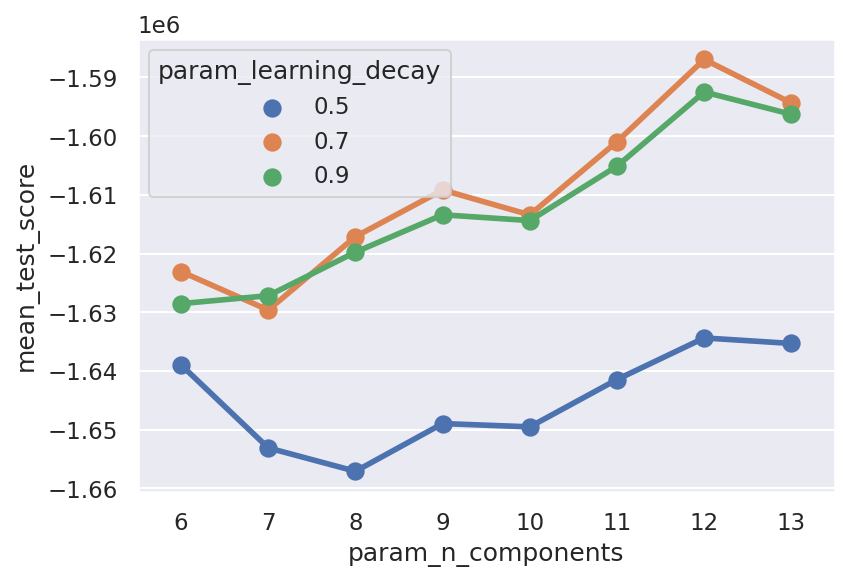

In [ ]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              hue="param_learning_decay",
              data=cv_results_df)

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,hearing,open,receive,back,level,help,health,work,offer,loss,close,next,cancel,thank,join
Topic 1,dental,health,access,pediatric,education,news,practice,pet,care,dentistry,member,oral,diabetes,center,dentist
Topic 2,news,privacy,said,policy,would,live,view,world,week,new,camp,good,contact,morning,use
Topic 3,test,blood,skin,diabetic,care,cancer,testing,medical,pressure,pain,insulin,feeding,food,screening,glucose
Topic 4,treatment,addiction,drug,alcohol,abuse,health,mental,substance,intake,dial,para,city,general,therapy,new
Topic 5,printing,beau,printed,data,medical,industry,new,education,additive,part,item,metal,job,business,market
Topic 6,center,member,health,news,policy,research,public,education,join,practice,volunteer,action,contact,find,login
Topic 7,medicine,client,banner,new,center,lake,ago,search,east,job,park,home,site,west,hill
Topic 8,sleep,search,skip,home,drug,medical,food,education,allergy,program,practice,advocacy,medicine,clinical,page
Topic 9,family,medicine,care,health,medical,primary,practice,news,member,course,home,academy,join,advocacy,may


In [ ]:
print(topic_keywords)
# print out first 8 topics
for i, topic in enumerate(topic_keywords.print_topics(8)):
    print ('%d: %s\n'%(i+1, topic))

[array(['hearing', 'open', 'receive', 'back', 'level', 'help', 'health',
       'work', 'offer', 'loss', 'close', 'next', 'cancel', 'thank',
       'join'], dtype='<U9'), array(['dental', 'health', 'access', 'pediatric', 'education', 'news',
       'practice', 'pet', 'care', 'dentistry', 'member', 'oral',
       'diabetes', 'center', 'dentist'], dtype='<U9'), array(['news', 'privacy', 'said', 'policy', 'would', 'live', 'view',
       'world', 'week', 'new', 'camp', 'good', 'contact', 'morning',
       'use'], dtype='<U9'), array(['test', 'blood', 'skin', 'diabetic', 'care', 'cancer', 'testing',
       'medical', 'pressure', 'pain', 'insulin', 'feeding', 'food',
       'screening', 'glucose'], dtype='<U9'), array(['treatment', 'addiction', 'drug', 'alcohol', 'abuse', 'health',
       'mental', 'substance', 'intake', 'dial', 'para', 'city', 'general',
       'therapy', 'new'], dtype='<U9'), array(['printing', 'beau', 'printed', 'data', 'medical', 'industry',
       'new', 'education', 'a

In [ ]:
Topics = ["Work health","Dentistry","New/Newcast","Diabetes","Addiction", "Industrialization",
          "Health voluntarisme", "Environment","Nutrition", "Family Medecine","Topic 11", "Blood tests"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,hearing,open,receive,back,level,help,health,work,offer,loss,close,next,cancel,thank,join,Work health
Topic 1,dental,health,access,pediatric,education,news,practice,pet,care,dentistry,member,oral,diabetes,center,dentist,Dentistry
Topic 2,news,privacy,said,policy,would,live,view,world,week,new,camp,good,contact,morning,use,New/Newcast
Topic 3,test,blood,skin,diabetic,care,cancer,testing,medical,pressure,pain,insulin,feeding,food,screening,glucose,Diabetes
Topic 4,treatment,addiction,drug,alcohol,abuse,health,mental,substance,intake,dial,para,city,general,therapy,new,Addiction
Topic 5,printing,beau,printed,data,medical,industry,new,education,additive,part,item,metal,job,business,market,Industrialization
Topic 6,center,member,health,news,policy,research,public,education,join,practice,volunteer,action,contact,find,login,Health voluntarisme
Topic 7,medicine,client,banner,new,center,lake,ago,search,east,job,park,home,site,west,hill,Environment
Topic 8,sleep,search,skip,home,drug,medical,food,education,allergy,program,practice,advocacy,medicine,clinical,page,Nutrition
Topic 9,family,medicine,care,health,medical,primary,practice,news,member,course,home,academy,join,advocacy,may,Family Medecine


In [ ]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(doc))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
# Styling
def color_green(val):
 color = "green" if val > .1 else "black"
 return "color: {col}".format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return "font-weight: {weight}".format(weight=weight)
# Apply Style

# df_document_topics.to_excel('final.xlsx', index=False) 

df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,dominant_topic
Doc0,0.00,0.00,0.00,0.21,0.00,0.23,0.00,0.00,0.15,0.29,0.00,0.11,9
Doc1,0.01,0.93,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc2,0.00,0.28,0.18,0.00,0.00,0.07,0.00,0.09,0.03,0.00,0.00,0.35,11
Doc3,0.05,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.64,11
Doc4,0.00,0.21,0.07,0.22,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.32,11
Doc5,0.11,0.00,0.00,0.00,0.62,0.00,0.10,0.00,0.07,0.00,0.00,0.09,4
Doc6,0.01,0.59,0.01,0.01,0.19,0.01,0.01,0.01,0.01,0.01,0.01,0.16,1
Doc7,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.87,0.00,0.00,9
Doc8,0.01,0.59,0.01,0.01,0.18,0.01,0.01,0.17,0.01,0.01,0.01,0.01,1
Doc9,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.79,0.00,0.00,9


In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
# topic_weights = []
# for i in enumerate(df_topic_keywords.print_topics(8)):
#     topic_weights.append([w for i, w in row_list[0]])
topic_weights = topic_keywords
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


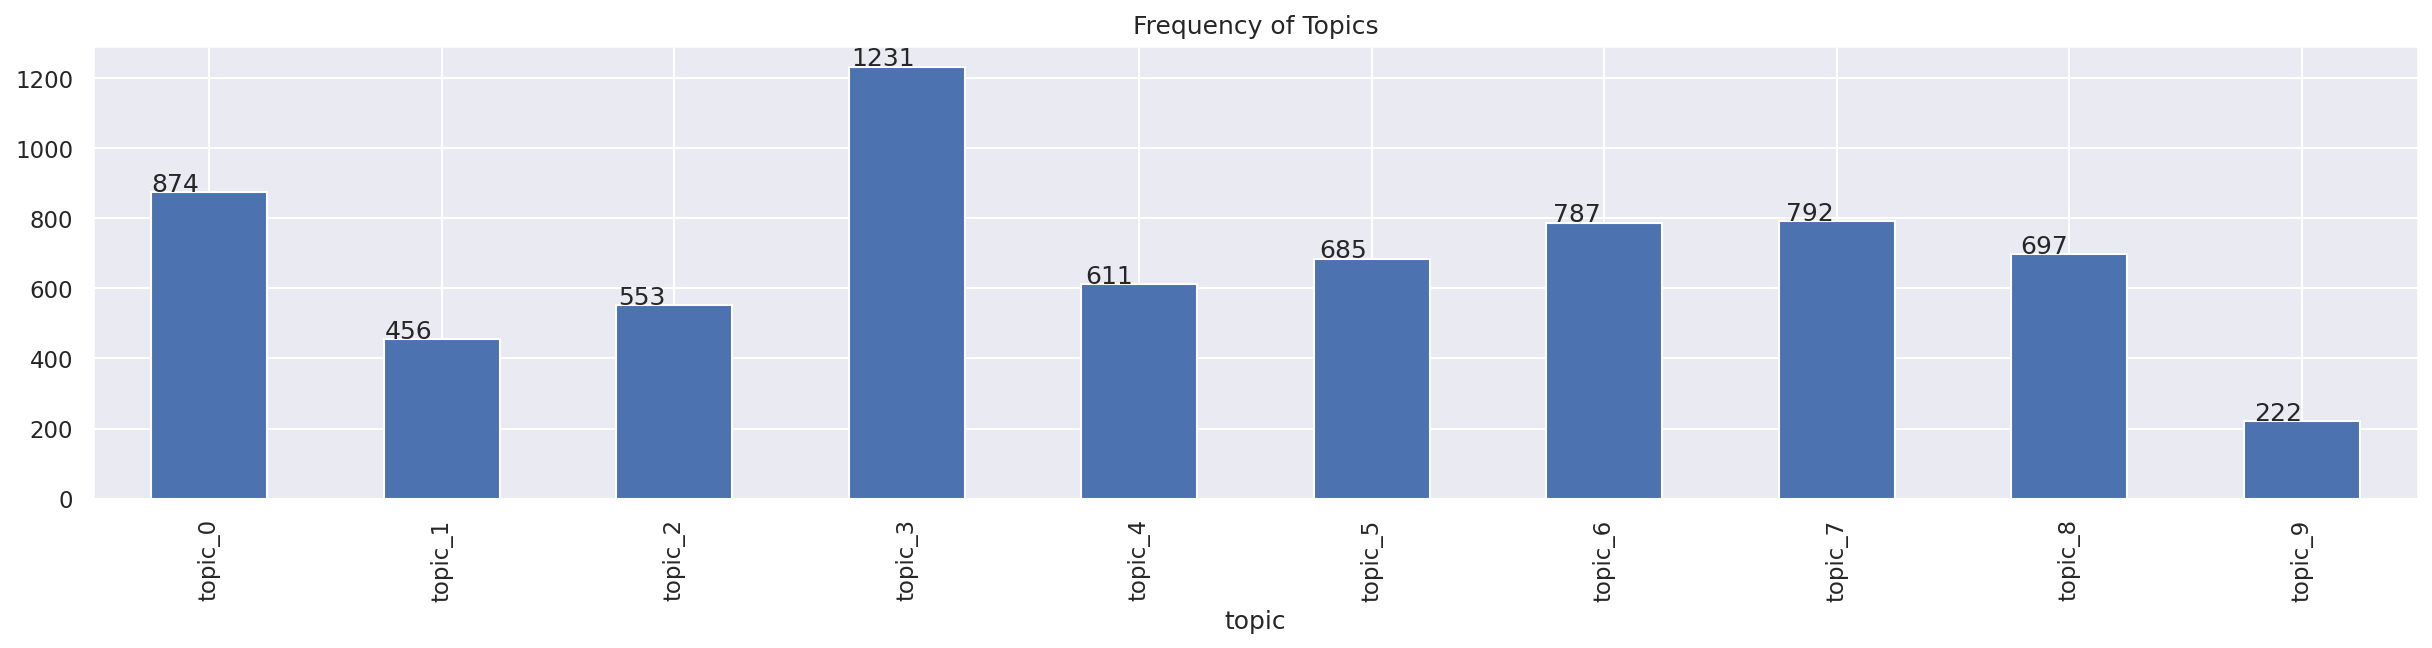

In [ ]:
from matplotlib import pyplot as plt

# fig = plt.figure(figsize=(10,4))
plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

*************** MODEL EVALUATION  ****************

In [ ]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=4,
                                    topic_num_end=15,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10,
                                            random_state=0)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus), 
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [ ]:
ts = 4
te = 15
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=doc, cv=vectorizer, cv_matrix=data_vectorized) 

4
5
6
7
8
9
10
11
12
13
14


In [ ]:
coherence_scores

[0.6020700229237035,
 0.7135723253165116,
 0.6305497570844043,
 0.6421290215506257,
 0.6653589784038626,
 0.6105732408948166,
 0.6369827316295271,
 0.6439776021277063,
 0.6285444648184056,
 0.5908978993627623,
 0.608560371513164]

In [ ]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [str(i) for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)

,TOPIC_NUMBER,COHERENCE_SCORE
1,5,0.7136
4,8,0.6654
7,11,0.6440
3,7,0.6421
6,10,0.6370
2,6,0.6305
8,12,0.6285
5,9,0.6106
10,14,0.6086
0,4,0.6021


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


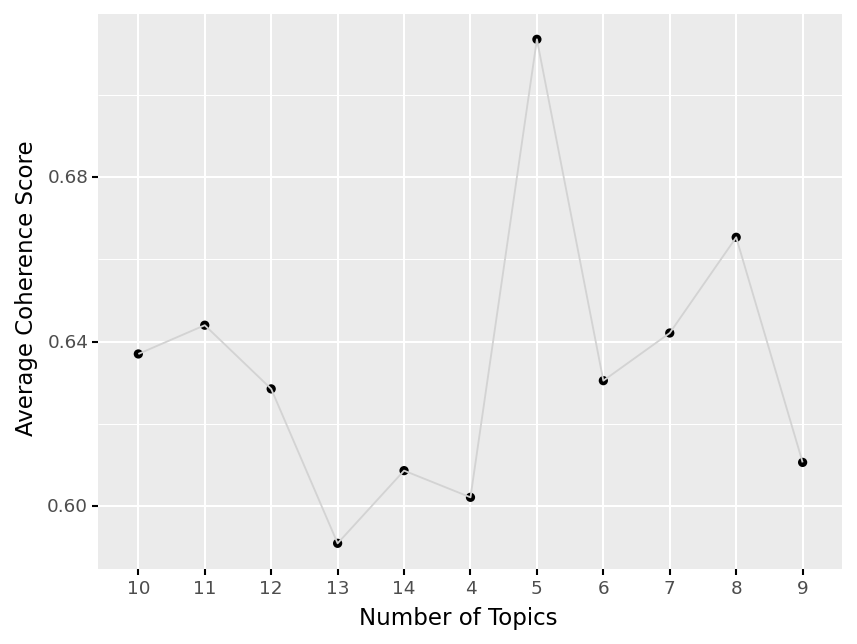

<ggplot: (8741654248297)>

In [ ]:
import plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
plotnine.options.dpi = 150

g = (ggplot(coherence_df) + aes(x="TOPIC_NUMBER", y="COHERENCE_SCORE") +
     geom_point(stat="identity") + geom_line(group=1, color="lightgrey") +
     labs(x="Number of Topics", y="Average Coherence Score"))
g